# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1. Introduction <a name="introduction"></a>
### 1.1. Background
A chain of popular estate agents, within the UK, is looking for a USP to bring into their brand. There is currently saturation in the market for estate agents and they feel that they need to stand out if they are to prosper.

A large number of their customer base are people who have had to relocate and are looking for somewhere similar to where they are moving from. They have enlisted a Data Scientist to create a new feature to their website called 'Relocation Finder'
### 1.2. Problem
We need to be able to recommend areas that are simular to the clients current location, so that we can focus where to search. We would like to run a POC only using data for Hertfordshire and Cambridgeshire and many factors need to be taken into account, such as:
- Population size
- Crime rate
- Local amenities

### 1.3.Target
Initially this will be for our senior managers to evaluate, based on their current knowledge of the area.

## 2. Data acquisition and cleaning
### 2.1. Data Sources
The data for postcodes, population sizes and LSOAs can all be obtained from **www.doogal.co.uk**. The crime data was downloaded from **www.data.police.uk/**. For ammenity data a **Foursquare** API was used. <a name="data"></a>

#### Import libraries

In [150]:
import pandas as pd
import os
import glob
import numpy as np
from functools import reduce
import requests
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors

#### Get postcode, population and LSAO data

In [178]:
postcodes_east = 'https://www.doogal.co.uk/UKPostcodesCSV.ashx?region=E12000006'

In [179]:
df_pc = pd.read_csv(postcodes_east)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Tidy up postcode dataset

Review dataset entities and data

In [180]:
df_pc.columns

Index(['Postcode', 'In Use?', 'Latitude', 'Longitude', 'Easting', 'Northing',
       'Grid Ref', 'County', 'District', 'Ward', 'District Code', 'Ward Code',
       'Country', 'County Code', 'Constituency', 'Introduced', 'Terminated',
       'Parish', 'National Park', 'Population', 'Households', 'Built up area',
       'Built up sub-division', 'Lower layer super output area', 'Rural/urban',
       'Region', 'Altitude', 'London zone', 'LSOA Code', 'Local authority',
       'MSOA Code', 'Middle layer super output area', 'Parish Code',
       'Census output area', 'Constituency Code',
       'Index of Multiple Deprivation', 'Quality', 'User Type', 'Last updated',
       'Nearest station', 'Distance to station', 'Postcode area',
       'Postcode district', 'Police force', 'Water company', 'Plus Code',
       'Average Income'],
      dtype='object')

In [181]:
df_pc.head()

,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,County,District,Ward,...,User Type,Last updated,Nearest station,Distance to station,Postcode area,Postcode district,Police force,Water company,Plus Code,Average Income
0,AL1 1AA,No,51.749084,-0.341337,514600,206900,TL146068,Hertfordshire,St Albans,Verulam,...,1,2020-02-19,St.Albans Abbey,0.490933,AL,AL1,Hertfordshire,NaN,9C3XPMX5+JF,68900
1,AL1 1AB,No,51.747828,-0.301865,517328,206823,TL173068,Hertfordshire,St Albans,Ashley,...,1,2020-02-19,St.Albans City,1.790470,AL,AL1,Hertfordshire,NaN,9C3XPMXX+47,66500
2,AL1 1AD,No,51.747828,-0.301865,517328,206823,TL173068,Hertfordshire,St Albans,Ashley,...,1,2020-02-19,St.Albans City,1.790470,AL,AL1,Hertfordshire,NaN,9C3XPMXX+47,66500
3,AL1 1AE,No,51.747828,-0.301865,517328,206823,TL173068,Hertfordshire,St Albans,Ashley,...,1,2020-02-19,St.Albans City,1.790470,AL,AL1,Hertfordshire,NaN,9C3XPMXX+47,66500
4,AL1 1AF,No,51.749084,-0.341337,514600,206900,TL146068,Hertfordshire,St Albans,Verulam,...,1,2020-02-19,St.Albans Abbey,0.490933,AL,AL1,Hertfordshire,NaN,9C3XPMX5+JF,68900


Only include data for POC

In [182]:
Counties = ['Hertfordshire', 'Cambridgeshire']
df_pc = df_pc[df_pc['County'].isin(Counties)]

In [183]:
# New attribute for averaging later
df_pc['Total_Income'] = df_pc['Average Income'] * df_pc['Households']

# Only required attributes
df_pc = df_pc[['LSOA Code','Postcode district','Postcode','County','Ward','Population','Households','Total_Income','Latitude','Longitude']]

# Drop all rows with NAs
df_pc = df_pc.dropna()

In [185]:
# Create aggregated dataframe
df_pc_g = (df_pc.groupby('LSOA Code', as_index=False)
       .agg({'Population' : 'sum', 'Households':'sum', 'Total_Income':'sum','Latitude':'mean','Longitude':'mean'}))

# Concatinate districts and wards onto single line
df_pc_dist = df_pc.groupby(['LSOA Code','Postcode district']).sum().reset_index()
df_pc_ward = df_pc.groupby(['LSOA Code','Ward']).sum().reset_index()
df_pc_pc = df_pc.groupby(['LSOA Code','Postcode']).sum().reset_index()
df_pc_dist = df_pc_dist.groupby(['LSOA Code'])['Postcode district'].apply(', '.join).reset_index()
df_pc_ward = df_pc_ward.groupby(['LSOA Code'])['Ward'].apply(', '.join).reset_index()
df_pc_pc = df_pc_pc.groupby(['LSOA Code'])['Postcode'].apply(', '.join).reset_index()

#Merge dataframes
data_frames = [df_pc_g, df_pc_dist, df_pc_ward,df_pc_pc]

df_pc_g = reduce(lambda  left,right: pd.merge(left,right,on=['LSOA Code'],
                                            how='inner'), data_frames)

df_pc_g['Average Income'] = df_pc_g['Total_Income'] / df_pc_g['Households']

In [186]:
df_pc_g.head()

,LSOA Code,Population,Households,Total_Income,Latitude,Longitude,Postcode district,Ward,Postcode,Average Income
0,E01015589,1663.0,670.0,35108000.0,52.631416,-0.366588,"PE6, PE9",Barnack,"PE6 7BF, PE6 7DF, PE6 7DG, PE6 7DJ, PE6 7DL, P...",52400.0
1,E01015590,1211.0,528.0,27667200.0,52.635478,-0.430694,PE9,Barnack,"PE9 3DL, PE9 3DN, PE9 3DP, PE9 3DR, PE9 3DS, P...",52400.0
2,E01015591,1479.0,587.0,23127800.0,52.599794,-0.289286,PE3,Bretton,"PE3 8BA, PE3 8HP, PE3 8HR, PE3 8HS, PE3 8JA, P...",39400.0
3,E01015592,1529.0,644.0,25373600.0,52.599438,-0.280389,PE3,Bretton,"PE3 8ES, PE3 8ET, PE3 8EU, PE3 8JB, PE3 8JD, P...",39400.0
4,E01015593,1430.0,571.0,19528200.0,52.601026,-0.277007,PE3,Bretton,"PE3 8EQ, PE3 8JW, PE3 8NA, PE3 8NB, PE3 8NH, P...",34200.0


### Prepare Crime dataset

In [187]:
# Load all crime files
path = r'./Crime_Logs' # use your path
all_files = glob.glob(path + "/*.csv")

df_c = []
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_c = pd.concat(li, axis=0, ignore_index=True)
df_c = df_c[['LSOA code','Crime type']]

In [188]:
# View the different types for crime and catagories
df_c.groupby('Crime type').count()

,LSOA code
Crime type,
Anti-social behaviour,59455
Bicycle theft,6754
Burglary,26525
Criminal damage and arson,32800
Drugs,10610
Other crime,6607
Other theft,31797
Possession of weapons,3524
Public order,30359


In [189]:
# Define crime catagories
serious_crime = ['Violence and sexual offences','Robbery','Possession of weapons','Criminal damage and arson','Burglary','Drugs']
theft = ['Bicycle theft','Other theft','Theft from the person','Shoplifting']
minor_crime = ['Anti-social behaviour','Other crime','Public order','Vehicle crime']
df = pd.DataFrame (serious_crime,columns=['Crime type'])
df['crime_cat'] = 'serious_crime'
df1 = pd.DataFrame (theft,columns=['Crime type'])
df1['crime_cat'] = 'theft'
df2 = pd.DataFrame (minor_crime,columns=['Crime type'])
df2['crime_cat'] = 'minor_crime'
df_cc = pd.concat([df,df1,df2])

#Merge with main dataset
df_c = pd.merge(df_c,df_cc,on = 'Crime type')

In [190]:
# Cruime count by bucket
df_c_g = df_c.groupby(['LSOA code','crime_cat'])['Crime type'].count().reset_index(name='crime_count')

#Reshape for import
df_c_g = df_c_g.pivot(index='LSOA code', columns='crime_cat', values='crime_count')
df_c_g.reset_index(inplace=True)

In [191]:
df_c_g.head()

crime_cat,LSOA code,minor_crime,serious_crime,theft
0,E01000001,1.0,5.0,9.0
1,E01000002,7.0,13.0,21.0
2,E01000005,8.0,12.0,7.0
3,E01000007,19.0,88.0,50.0
4,E01000009,NaN,1.0,NaN


## Create master dataset

In [192]:
# join datasets
df_pc_g = pd.merge(df_pc_g,df_c_g,left_on='LSOA Code',right_on='LSOA code')

In [193]:
# crimes per 100 residence
df_pc_g['minor_crime_per100'] = (df_pc_g['minor_crime'] / df_pc_g['Population']) * 100
df_pc_g['theft_crime_per100'] = (df_pc_g['theft'] / df_pc_g['Population']) * 100
df_pc_g['serious_crime_per100'] = (df_pc_g['serious_crime'] / df_pc_g['Population']) * 100

In [194]:
cols_to_norm = ['Population','Households','Average Income','minor_crime_per100','theft_crime_per100','serious_crime_per100']
df_pc_g[cols_to_norm] = df_pc_g[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [195]:
df_pc_g = df_pc_g[['LSOA Code','Postcode','Postcode district','Ward','Latitude','Longitude','Population','Households','Average Income','minor_crime_per100','theft_crime_per100','serious_crime_per100']]

In [196]:
df_pc_g.head()

,LSOA Code,Postcode,Postcode district,Ward,Latitude,Longitude,Population,Households,Average Income,minor_crime_per100,theft_crime_per100,serious_crime_per100
0,E01015592,"PE3 8ES, PE3 8ET, PE3 8EU, PE3 8JB, PE3 8JD, P...",PE3,Bretton,52.599438,-0.280389,0.258683,0.295685,0.122917,0.001450,NaN,NaN
1,E01015597,"PE3 6YJ, PE3 9JT, PE3 9JU, PE3 9XS, PE3 9XT, P...",PE3,West,52.579872,-0.287173,0.281493,0.255076,0.122917,0.001355,NaN,0.004056
2,E01015599,"PE1 1DD, PE1 1DH, PE1 1EH, PE1 1EP, PE1 1ER, P...",PE1,Central,52.574708,-0.243763,0.444272,0.407360,0.085417,0.075386,0.073401,0.099917
3,E01015609,"PE1 4PX, PE1 4QL, PE1 4QN, PE1 4TH, PE1 4TJ, P...",PE1,Dogsthorpe,52.597415,-0.219018,0.355625,0.310914,0.037500,NaN,NaN,0.000987
4,E01015615,"PE1 4BH, PE1 4LB, PE1 4RA, PE1 4RB, PE1 4RD, P...",PE1,East,52.585948,-0.222546,0.326594,0.357868,0.068750,NaN,NaN,0.001075


In [197]:
df_pc_g.shape

(742, 12)

## Foursquare credentials

In [168]:
#%Hiddden
CLIENT_ID = 'MJWUIBMX1SWKOYEY1EJRX5VJY0XEKB0WTSFPL5REETSYSDCS' # your Foursquare ID
CLIENT_SECRET = 'LEMDCRVTUYLDDUL0YAZB4GPLKVTMFZK1UCG3A5SYMTTCUA3R' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
radius = 500

### Methodology <a name="methodology"></a>
In this project we will direct our efforts on detecting the top 10 venue types within 500 metres the centriod point of a LSOA.

In first step we have collected the required **data: location and type (category) of every venue within 500 metres from LSOA center**.

Second step in our analysis will be calculation and exploration of '**top venues**' across different LSOA areas

In third and final step we will focus on creating **clusters of locations based on key metrics** 

In [108]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    global results
    global venues_list
    global nearby_venues
    global url
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['LSOA Code',
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [109]:
local_venues = getNearbyVenues(names= df_pc_g ['LSOA Code'],
                                   latitudes=df_pc_g ['Latitude'],
                                   longitudes=df_pc_g ['Longitude']
                                  )

E01015592
E01015597
E01015599
E01015609
E01015615
E01015621
E01015632
E01015633
E01015671
E01017987
E01018024
E01018026
E01018033
E01018035
E01018044
E01018076
E01018084
E01018090
E01018126
E01018135
E01018151
E01018152
E01018174
E01018176
E01018177
E01018181
E01018182
E01018183
E01018188
E01018190
E01018192
E01018197
E01018220
E01018226
E01018228
E01018239
E01018245
E01018246
E01018247
E01018265
E01018266
E01018268
E01018270
E01018271
E01018273
E01018275
E01018279
E01018289
E01018290
E01018293
E01018300
E01018302
E01023289
E01023290
E01023291
E01023292
E01023293
E01023294
E01023295
E01023296
E01023297
E01023298
E01023299
E01023300
E01023301
E01023302
E01023303
E01023304
E01023305
E01023306
E01023307
E01023308
E01023309
E01023310
E01023311
E01023312
E01023313
E01023314
E01023315
E01023316
E01023317
E01023318
E01023319
E01023320
E01023321
E01023322
E01023323
E01023324
E01023325
E01023326
E01023327
E01023328
E01023329
E01023330
E01023331
E01023332
E01023333
E01023334
E01023335
E01023336


In [113]:
local_venues.head()

,LSOA Code,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,E01015592,52.599438,-0.280389,Bretton Park,52.596114,-0.278392,Park
1,E01015597,52.579872,-0.287173,Copeland Bus Stop- North,52.578186,-0.288882,Bus Stop
2,E01015597,52.579872,-0.287173,Bretton Centre,52.579551,-0.290858,Shopping Mall
3,E01015597,52.579872,-0.287173,South Bretton Playing Fields,52.581148,-0.291889,Park
4,E01015597,52.579872,-0.287173,Nisa,52.576563,-0.290966,Convenience Store


Check dataframe dimentions

In [114]:
local_venues.shape

(3844, 7)

How many venues were returned for each neighborhood

In [115]:
local_venues.groupby('LSOA Code').count()

,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
LSOA Code,,,,,,
E01015592,1,1,1,1,1,1
E01015597,4,4,4,4,4,4
E01015599,30,30,30,30,30,30
E01015609,7,7,7,7,7,7
E01015615,5,5,5,5,5,5
...,...,...,...,...,...,...
E01033029,4,4,4,4,4,4
E01033308,26,26,26,26,26,26
E01033311,5,5,5,5,5,5


One hot encoding

In [117]:
# one hot encoding
local_onehot = pd.get_dummies(local_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
local_onehot['LSOA Code'] = local_venues['LSOA Code'] 

# move neighborhood column to the first column
fixed_columns = [local_onehot.columns[-1]] + list(local_onehot.columns[:-1])
local_onehot.head()

,Accessories Store,Advertising Agency,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Video Game Store,Warehouse Store,Water Park,Weight Loss Center,Windmill,Wine Bar,Wine Shop,Women's Store,Yoga Studio,LSOA Code
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E01015592
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E01015597
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E01015597
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E01015597
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E01015597


Examine the new dataframe size.

In [119]:
local_onehot.shape

(3844, 257)

Group rows by lsoa and by taking the mean of the frequency of occurrence of each category

In [120]:
local_grouped = local_onehot.groupby('LSOA Code').mean().reset_index()
local_grouped

,LSOA Code,Accessories Store,Advertising Agency,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Warehouse Store,Water Park,Weight Loss Center,Windmill,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,E01015592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,E01015597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,E01015599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0
3,E01015609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,E01015615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,E01033029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
677,E01033308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
678,E01033311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
679,E01033314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


Top 5 most common venues by lsoa

In [122]:
num_top_venues = 5

for lsoa in local_grouped['LSOA Code']:
    print("----"+lsoa+"----")
    temp = local_grouped[local_grouped['LSOA Code'] == lsoa].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----E01015592----
                  venue  freq
0                  Park   1.0
1     Accessories Store   0.0
2  Pakistani Restaurant   0.0
3            Nail Salon   0.0
4       Nature Preserve   0.0


----E01015597----
               venue  freq
0               Park  0.25
1  Convenience Store  0.25
2      Shopping Mall  0.25
3           Bus Stop  0.25
4          Nightclub  0.00


----E01015599----
                venue  freq
0         Coffee Shop  0.10
1        Burger Joint  0.07
2                 Bar  0.07
3                 Pub  0.07
4  Italian Restaurant  0.03


----E01015609----
                  venue  freq
0             Pet Store  0.29
1           Coffee Shop  0.14
2     Convenience Store  0.14
3         Garden Center  0.14
4  Outdoor Supply Store  0.14


----E01015615----
               venue  freq
0                Pub   0.2
1       Dessert Shop   0.2
2  Fish & Chips Shop   0.2
3            Brewery   0.2
4  Convenience Store   0.2


----E01015621----
                  venue  freq


Create the new dataframe and display the top 10 venues for each lsoa

In [123]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [124]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['LSOA Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
lsoa_venues_sorted = pd.DataFrame(columns=columns)
lsoa_venues_sorted['LSOA Code'] = local_grouped['LSOA Code']

for ind in np.arange(local_grouped.shape[0]):
    lsoa_venues_sorted.iloc[ind, 1:] = return_most_common_venues(local_grouped.iloc[ind, :], num_top_venues)

lsoa_venues_sorted.head()

,LSOA Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,E01015592,Park,Yoga Studio,English Restaurant,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish & Chips Shop,Film Studio
1,E01015597,Convenience Store,Shopping Mall,Park,Bus Stop,Flower Shop,Flea Market,Fish & Chips Shop,Film Studio,English Restaurant,Fast Food Restaurant
2,E01015599,Coffee Shop,Pub,Burger Joint,Bar,Brewery,English Restaurant,Restaurant,Steakhouse,Supermarket,Beer Bar
3,E01015609,Pet Store,Convenience Store,Garden Center,Shopping Plaza,Outdoor Supply Store,Coffee Shop,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Farmers Market
4,E01015615,Pub,Brewery,Dessert Shop,Fish & Chips Shop,Convenience Store,Food & Drink Shop,Food,Flower Shop,Flea Market,Entertainment Service


In [260]:
df_master = pd.merge(df_pc_g,lsoa_venues_sorted,on = 'LSOA Code')

In [199]:
df_master.head()

,LSOA Code,Postcode,Postcode district,Ward,Latitude,Longitude,Population,Households,Average Income,minor_crime_per100,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,E01015592,"PE3 8ES, PE3 8ET, PE3 8EU, PE3 8JB, PE3 8JD, P...",PE3,Bretton,52.599438,-0.280389,0.258683,0.295685,0.122917,0.001450,...,Park,Yoga Studio,English Restaurant,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish & Chips Shop,Film Studio
1,E01015597,"PE3 6YJ, PE3 9JT, PE3 9JU, PE3 9XS, PE3 9XT, P...",PE3,West,52.579872,-0.287173,0.281493,0.255076,0.122917,0.001355,...,Convenience Store,Shopping Mall,Park,Bus Stop,Flower Shop,Flea Market,Fish & Chips Shop,Film Studio,English Restaurant,Fast Food Restaurant
2,E01015599,"PE1 1DD, PE1 1DH, PE1 1EH, PE1 1EP, PE1 1ER, P...",PE1,Central,52.574708,-0.243763,0.444272,0.407360,0.085417,0.075386,...,Coffee Shop,Pub,Burger Joint,Bar,Brewery,English Restaurant,Restaurant,Steakhouse,Supermarket,Beer Bar
3,E01015609,"PE1 4PX, PE1 4QL, PE1 4QN, PE1 4TH, PE1 4TJ, P...",PE1,Dogsthorpe,52.597415,-0.219018,0.355625,0.310914,0.037500,NaN,...,Pet Store,Convenience Store,Garden Center,Shopping Plaza,Outdoor Supply Store,Coffee Shop,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Farmers Market
4,E01015615,"PE1 4BH, PE1 4LB, PE1 4RA, PE1 4RB, PE1 4RD, P...",PE1,East,52.585948,-0.222546,0.326594,0.357868,0.068750,NaN,...,Pub,Brewery,Dessert Shop,Fish & Chips Shop,Convenience Store,Food & Drink Shop,Food,Flower Shop,Flea Market,Entertainment Service


In [242]:
df_kmean = pd.merge(df_pc_g,local_onehot,on = 'LSOA Code')
df_kmean.head()

,LSOA Code,Postcode,Postcode district,Ward,Latitude,Longitude,Population,Households,Average Income,minor_crime_per100,...,Vegetarian / Vegan Restaurant,Video Game Store,Warehouse Store,Water Park,Weight Loss Center,Windmill,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,E01015592,"PE3 8ES, PE3 8ET, PE3 8EU, PE3 8JB, PE3 8JD, P...",PE3,Bretton,52.599438,-0.280389,0.258683,0.295685,0.122917,0.001450,...,0,0,0,0,0,0,0,0,0,0
1,E01015597,"PE3 6YJ, PE3 9JT, PE3 9JU, PE3 9XS, PE3 9XT, P...",PE3,West,52.579872,-0.287173,0.281493,0.255076,0.122917,0.001355,...,0,0,0,0,0,0,0,0,0,0
2,E01015597,"PE3 6YJ, PE3 9JT, PE3 9JU, PE3 9XS, PE3 9XT, P...",PE3,West,52.579872,-0.287173,0.281493,0.255076,0.122917,0.001355,...,0,0,0,0,0,0,0,0,0,0
3,E01015597,"PE3 6YJ, PE3 9JT, PE3 9JU, PE3 9XS, PE3 9XT, P...",PE3,West,52.579872,-0.287173,0.281493,0.255076,0.122917,0.001355,...,0,0,0,0,0,0,0,0,0,0
4,E01015597,"PE3 6YJ, PE3 9JT, PE3 9JU, PE3 9XS, PE3 9XT, P...",PE3,West,52.579872,-0.287173,0.281493,0.255076,0.122917,0.001355,...,0,0,0,0,0,0,0,0,0,0


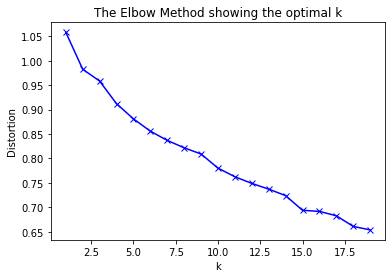

In [254]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

df_master_clustering = df_kmean.drop(['LSOA Code','Postcode district','Ward','Latitude','Longitude','Postcode'], 1)
df_master_clustering = df_master_clustering.dropna()
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_master_clustering)
    kmeanModel.fit(df_master_clustering)
    distortions.append(sum(np.min(cdist(df_master_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_master_clustering.shape[0])
    
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Run k-means to cluster the lsoa into 7 clusters

In [261]:
# set number of clusters
kclusters = 19

df_master_clustering = df_master.drop(['LSOA Code','Postcode district','Ward','Latitude','Longitude'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(local_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([12,  0,  3,  3,  0,  3,  3, 14,  2,  3,  3,  0, 10, 14,  3,  3,  3,
        3, 18,  0,  6,  6,  3, 18,  0,  0,  3,  0,  3,  6, 10, 10,  1,  6,
       14,  6,  0,  2,  7,  6,  6,  7, 11, 14,  6, 14,  2,  2,  2,  2,  0,
        0,  0,  0,  3, 14,  2, 12,  2, 14,  2,  3,  1, 10,  1,  2,  3,  6,
       14,  3,  4, 16,  2,  2, 10,  0, 10,  3, 10,  6,  6,  2,  3,  2,  3,
        3,  6, 14,  6,  6,  6,  3, 13,  2,  2,  2,  3,  3,  3,  3,  5,  3,
        6,  6,  0,  3, 14,  3,  3,  3,  6, 14,  3,  3,  6,  3, 13, 10, 11,
        6, 10, 14,  3,  6,  3,  6,  6,  2,  2,  2,  6,  3,  3,  3,  3,  7,
        2,  2,  8,  2,  3,  3,  6,  6, 10,  0, 18,  5, 10,  6,  8,  3,  6,
        0,  6, 10, 10,  0,  1, 16,  2,  6,  2,  3,  7, 14,  3, 14,  6, 15,
        2,  5,  3,  6, 10,  4,  0,  8,  0, 18, 18,  3,  3,  6,  6,  3,  3,
        3,  2,  0,  3,  3, 18, 12,  3,  3,  0,  0,  3,  3, 12,  3,  7, 14,
        4, 10,  3,  7,  3,  4,  2,  3,  6, 11,  3,  3,  3,  3, 14,  2,  3,
        2,  1,  3, 10, 10

In [262]:
# add clustering labels
df_master.insert(0, 'Cluster_Labels', kmeans.labels_)

df_master.head()

,Cluster_Labels,LSOA Code,Postcode,Postcode district,Ward,Latitude,Longitude,Population,Households,Average Income,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,12,E01015592,"PE3 8ES, PE3 8ET, PE3 8EU, PE3 8JB, PE3 8JD, P...",PE3,Bretton,52.599438,-0.280389,0.258683,0.295685,0.122917,...,Park,Yoga Studio,English Restaurant,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish & Chips Shop,Film Studio
1,0,E01015597,"PE3 6YJ, PE3 9JT, PE3 9JU, PE3 9XS, PE3 9XT, P...",PE3,West,52.579872,-0.287173,0.281493,0.255076,0.122917,...,Convenience Store,Shopping Mall,Park,Bus Stop,Flower Shop,Flea Market,Fish & Chips Shop,Film Studio,English Restaurant,Fast Food Restaurant
2,3,E01015599,"PE1 1DD, PE1 1DH, PE1 1EH, PE1 1EP, PE1 1ER, P...",PE1,Central,52.574708,-0.243763,0.444272,0.407360,0.085417,...,Coffee Shop,Pub,Burger Joint,Bar,Brewery,English Restaurant,Restaurant,Steakhouse,Supermarket,Beer Bar
3,3,E01015609,"PE1 4PX, PE1 4QL, PE1 4QN, PE1 4TH, PE1 4TJ, P...",PE1,Dogsthorpe,52.597415,-0.219018,0.355625,0.310914,0.037500,...,Pet Store,Convenience Store,Garden Center,Shopping Plaza,Outdoor Supply Store,Coffee Shop,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Farmers Market
4,0,E01015615,"PE1 4BH, PE1 4LB, PE1 4RA, PE1 4RB, PE1 4RD, P...",PE1,East,52.585948,-0.222546,0.326594,0.357868,0.068750,...,Pub,Brewery,Dessert Shop,Fish & Chips Shop,Convenience Store,Food & Drink Shop,Food,Flower Shop,Flea Market,Entertainment Service


In [263]:
# Covert cluster value to int
df_master['Cluster_Labels'] = df_master.Cluster_Labels.astype(int)

# Drop missing data
df_master=df_master.dropna()

In [264]:
address = 'Harpenden'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Toronto are 51.8148177, -0.3515572.


In [270]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_master['Latitude'], df_master['Longitude'], df_master['LSOA Code'], df_master['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [225]:
current_postalcode = input("Current Postcode")

Current Postcode AL3 5UB


In [265]:
# Find current cluster
current_pc = df_master[df_master['Postcode'].str.contains(current_postalcode)]
current_cluster = current_pc['Cluster_Labels'].sum()

In [266]:
df_relocation = df_master[df_master['Cluster_Labels'] == current_cluster]

In [267]:
df_relocation.head()

,Cluster_Labels,LSOA Code,Postcode,Postcode district,Ward,Latitude,Longitude,Population,Households,Average Income,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
71,16,E01023325,"EN7 6EP, EN7 6ER, EN7 6ES, EN7 6ET, EN7 6EU, E...",EN7,"Flamstead End, Rosedale and Bury Green",51.712156,-0.057830,0.202696,0.265228,0.183333,...,Pub,Playground,English Restaurant,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish & Chips Shop,Film Studio
159,16,E01023416,"HP23 5RE, HP23 5RG, HP4 1LA, HP4 1LB, HP4 1LE,...","HP23, HP4",Northchurch,51.773993,-0.597258,0.216174,0.300761,0.402083,...,Playground,Yoga Studio,English Restaurant,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish & Chips Shop,Film Studio
346,16,E01023620,"SG4 0NE, SG4 0NF, SG4 0NH, SG4 0NJ, SG4 0NL, S...",SG4,Hitchin Walsworth,51.953199,-0.249655,0.152411,0.148477,0.339583,...,Park,Playground,Yoga Studio,Film Studio,Event Service,Event Space,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
347,16,E01023621,"SG4 0DL, SG4 0DN, SG4 0DP, SG4 0DR, SG4 0DS, S...",SG4,Hitchin Walsworth,51.948795,-0.250854,0.163815,0.228426,0.339583,...,Playground,Martial Arts Dojo,Park,Nature Preserve,Yoga Studio,Fast Food Restaurant,Event Space,Farm,Farmers Market,Fish & Chips Shop
384,16,E01023664,"AL4 0DH, AL4 0DJ, AL4 0DL, AL4 0DN, AL4 0DP, A...",AL4,Ashley,51.751527,-0.296933,0.388284,0.312183,0.687500,...,Playground,Pub,Trail,Park,Yoga Studio,Farmers Market,Entertainment Service,Event Service,Event Space,Farm


In [268]:
df_relocation.shape

(8, 23)

In [273]:
# create map
poss_locations = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_relocation['Latitude'], df_relocation['Longitude'], df_relocation['LSOA Code'], df_relocation['Ward']):
    label = folium.Popup(str(poi) + ' Ward ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(poss_locations)
       
poss_locations

### Results and Discussion <a name="results"></a>
Using the example of AL3 5UB, which is well known to the client, shows 63 possible simular locations. The client has reviewed and believes these to be matching to the desired confidence. There are more improvements needed however, as the popluation composition needs to be taken into account. It would be benificial to draw out the population age and social charactoristics

### Conclusion <a name="conclusion"></a>
The clustering has given a good estimation of where clients need to focus their searches whilst relocating. It is now important to add in more attributes to the clustering and also make the analysis country wide 